In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import plotly.plotly as py
from plotly.graph_objs import *

from __future__ import division
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sklearn.preprocessing as skpp
from pandas.tools.plotting import scatter_matrix

In [30]:
df_tt = pd.read_csv('/Users/Taha/Desktop/datascience/notebooks/edmodo/cluster-districts-export-v2.csv')


In [31]:
df_tt.count()

2014-07-01               2575286
7                        2575286
1991                     2575286
San Carlos Elementary    2575286
CA                       2575286
San Mateo                2571284
5                        2575286
26                       2575286
8                        2575286
72                       2575286
218                      2575286
154                      2575286
dtype: int64

In [16]:
df_original = df_t.groupby(['id'],as_index=False)

In [24]:
df_original = df_t.groupby(['id'],as_index=False).agg({'name':'count'})

In [26]:
df_original.count()

id      4145
name    4145
dtype: int64

/Users/Taha/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:55: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.

/Users/Taha/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:58: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.

/Users/Taha/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:61: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



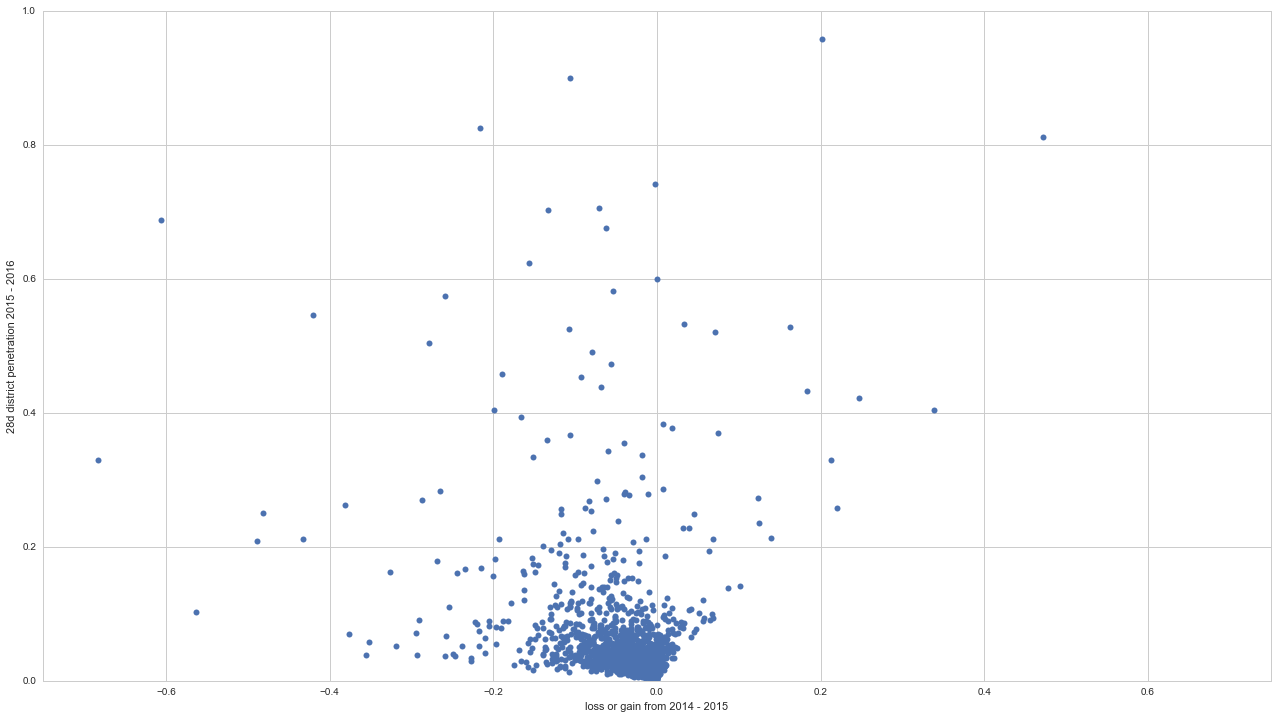

In [35]:
df = pd.read_csv('/Users/Taha/Desktop/datascience/notebooks/edmodo/cluster-districts-export-v2.csv')

# -----------------------

df = df.set_index('date')
df['date'] = df.index

# -----------------------

def get_period(date):
    if ( date[0:4] == '2014'and date[5:7] in ('08','09','10','11','12') ) or ( date[0:4]=='2015'and date[5:7] in ('01',
                                                                                                '02','03','04','05') ):
        return '14-15'
    if ( date[0:4] == '2015'and date[5:7] in ('08','09','10','11','12') ) or ( date[0:4]=='2016'and date[5:7] in ('01',
                                                                                            '02','03','04','05') ):
        return '15-16'
    if ( date[0:4] == '2015'and date[5:7] in ('06','07') ):
        return 'summer 14-15'
    else:
        return 'no period'
    
df['period'] = df['date'].apply(get_period)

# -----------------------

df = df[ df['date'] > '2014-07-31' ]
df = df[df['nces_teachers'] >= 100]
df = df[df['28d'] > 5]

# -----------------------

df_14_15 = df[ df['period'] == '14-15']
df_15_16 = df[ df['period'] == '15-16']
df_s_14_15 = df[ df['period'] == 'summer 14-15']

# -----------------------

df_14_15_g = df_14_15.groupby(['id'],as_index=False).agg({'28d':['mean','std'],'nces_teachers':'max', 'name':'max'})
df_15_16_g = df_15_16.groupby(['id'],as_index=False).agg({'28d':['mean','std'], 'nces_teachers':'max', 'name':'max'})
df_s_14_15_g = df_s_14_15.groupby(['id'],as_index=False).agg({'28d':['mean','std'],'nces_teachers':'max', 'name':'max'})

# -----------------------

df_14_15_g['mean'] = df_14_15_g['28d']['mean']
df_14_15_g['std']  = df_14_15_g['28d']['std']

df_15_16_g['mean'] = df_15_16_g['28d']['mean']
df_15_16_g['std']  = df_15_16_g['28d']['std']

df_s_14_15_g['mean'] = df_s_14_15_g['28d']['mean']
df_s_14_15_g['std']  = df_s_14_15_g['28d']['std']

# -----------------------

df_14_15_g = df_14_15_g.drop('28d', 1)
df_14_15_g.columns = df_14_15_g.columns.droplevel(1)

df_15_16_g = df_15_16_g.drop('28d', 1)
df_15_16_g.columns = df_15_16_g.columns.droplevel(1)

df_s_14_15_g = df_s_14_15_g.drop('28d', 1)
df_s_14_15_g.columns = df_s_14_15_g.columns.droplevel(1)

# -----------------------

df_graph = pd.merge(df_14_15_g[['id','mean','name','nces_teachers']], df_15_16_g[['id', 'mean','name','nces_teachers']], on='id')
df_graph = df_graph.drop(['name_y','nces_teachers_y'],1)
df_graph = df_graph.rename(columns={'mean_x':'28d_14_15', 'mean_y':'28d_15_16','name_x':'name','nces_teachers_x':'teachers'})
df_graph.head()

# -----------------------

df_graph['diff'] = df_graph['28d_15_16'] - df_graph['28d_14_15']

# -----------------------

df_graph['pen_28d_14_15'] = df_graph['28d_14_15'] / df_graph['teachers']
df_graph['pen_28d_15_16'] = df_graph['28d_15_16'] / df_graph['teachers']

# -----------------------

df_graph['loss_or_gain'] = df_graph['diff'] / df_graph['teachers']
df_graph.head()

# -----------------------

fig, ax = plt.subplots()

ax.plot(df_graph.loss_or_gain, df_graph.pen_28d_15_16, marker='o', linestyle='', ms=6)

ax.set_xlabel("loss or gain from 2014 - 2015")
ax.set_ylabel("28d district penetration 2015 - 2016")

ax.set_xlim([-0.75,0.75])
ax.set_ylim([0,1])

# #best fit line
# ax.plot(df_graph.pen_7d_14_15, 
#         np.poly1d(np.polyfit(df_graph.pen_7d_14_15, df_graph.pen_7d_15_16, 1))(df_graph.pen_7d_14_15),
#          lw=0.025, linestyle='--', color='red')

# # if means from both years are the same, then linear line
# x_ideal = [0,0.2,0.4,0.6,0.8,0.85]
# y_ideal = [0,0.2,0.4,0.6,0.8,0.85]
# ax.plot(x_ideal, y_ideal, lw=0.05)

fig.set_size_inches(22, 12)
plt.show()

# -----------------------


In [36]:
df_graph.count()

id               2278
28d_14_15        2278
name             2278
teachers         2278
28d_15_16        2278
diff             2278
pen_28d_14_15    2278
pen_28d_15_16    2278
loss_or_gain     2278
dtype: int64

In [259]:
#df_graph.to_csv('district_loss_or_grain.csv')

In [5]:
def get_delta_q(df_graph):
    if df_graph['loss_or_gain'] > 0 and df_graph['pen_28d_15_16'] >= 0.3:
        return 'q1'
    if df_graph['loss_or_gain'] > 0 and df_graph['pen_28d_15_16'] < 0.3:
        return 'q4'
    if df_graph['loss_or_gain'] < 0 and df_graph['pen_28d_15_16'] >= 0.3:
        return 'q2'
    if df_graph['loss_or_gain'] < 0 and df_graph['pen_28d_15_16'] < 0.3:
        return 'q3'

df_graph['quadrant']= df_graph.apply(get_delta_q, axis=1)


In [37]:
# df_graph[['id','name',
#           'teachers',
#           '28d_14_15',
#           '28d_15_16',
#           'loss_or_gain',
#           'pen_28d_15_16']].loc[df_graph['quadrant'] == 'q3' ].sort_values(by='loss_or_gain',ascending=True)